# Introduction
Eq 2 of [PRL 119, 253904 (2017)](https://doi.org/10.1103/PhysRevLett.119.253904) gives, for no magnetic field $\Omega=0$, no spin-orbit coupling $\beta=0$, no loss $\gamma=0$, no pumping $h_\pm=0$ and no non-linear terms:
$$
\frac{1}{2}\left(\partial_x^2+\partial_y^2+2ik\partial_y-k^2\right)u-\mathcal{R}u+\varepsilon u=0.
$$
Due to periodicity the correct FT of $u$ and $\mathcal{R}$ will have discrete Fourier coefficients ${u}_G$ and ${\mathcal{R}}_G$:
$$
u(x,y)=\sum_G\, u_G \,e^{i\bf{G}\cdot \bf{r}},
$$ and
$$
\mathcal{R}(x,y)=\sum_G\, \mathcal{R}_G \,e^{i\bf{G}\cdot \bf{r}},
$$ where 

$$
 G \equiv (G_x,G_y)^T \equiv \left(\frac{2\pi n}{L_x}, \frac{2\pi m}{L_y}\right)^T
$$

so that 

$$
\partial_x\xrightarrow{}{iG_x},\quad \implies \partial_x^2\xrightarrow{}{-G_x^2} \\
\partial_y\xrightarrow{}{iG_y},\quad \implies \partial_y^2\xrightarrow{}{-G_y^2}
$$

Then the equation 
$$
\frac{1}{2}\left(\partial_x^2+\partial_y^2+2ik\partial_y-k^2\right)u-\mathcal{R}u+\varepsilon u=0,
$$
becomes using the Fourier expansions of $u$ and $\mathcal{R}$
$$
\sum_G\frac{1}{2}\left(-G_x^2-G_y^2-2kG_y-k^2\right)u_Ge^{iG\cdot r}-\sum_{GG'}\mathcal{R}_{G'}u_Ge^{i(G'+G)\cdot r}=-\varepsilon \sum_G u_G e^{iG\cdot r}.
$$
Moving the indices in double sum several times we realise that it is the same as:
$$
\sum_{GG'}\mathcal{R}_{G'}u_Ge^{i(G'+G)\cdot r}=\sum_{GG'}\mathcal{R}_{G-G'}u_{G'}e^{iG\cdot r}
$$

giving us an eigenvalue equation over the basis $e^{iG\cdot r}$:
$$
\frac{1}{2}\left(G_x^2+(k+G_y)^2\right)u_G+\sum_{G'}\mathcal{R}_{G-G'}u_{G'}=\varepsilon\,u_G
$$
---
We will do the following steps:
- [x] Define R function
- [x] Calculate plane-wave expansion coefficients of R 
- [ ] Build hamiltonian matrix and find eigenvalues

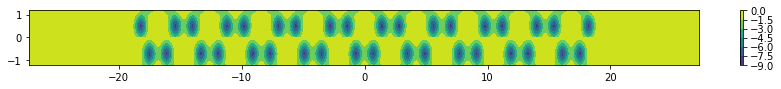

In [1]:
#Define R(x,y) function for lattice of gaussians

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# PRL 119, 253904 (2017)
#https://doi.org/10.1103/PhysRevLett.119.253904

a = 1.4*np.sqrt(3) #lattice constant
b = a/np.sqrt(3) # this is variable 'a' in the paper
uc_pillars = [(0,0),       (0.5*b, 0.5*np.sqrt(3)*b), 
             (1.5*b,0.5*np.sqrt(3)*b), (2*b,0)] 
             #4 pillars' coordinates in the rectangular unit cell
cell_width = np.sqrt(3)*a
cell_height = a
num_cells = 9
paddingx = cell_width*2
#supercell width and height
Lx = 2*paddingx + cell_width*num_cells
Ly = cell_height

def principaly(y):
    return np.abs(cell_height*(y/cell_height-np.floor(y/cell_height)))

def pillar(coord,pillarindex):
    x,y = coord
    i,j = pillarindex
    ym = j*cell_height + uc_pillars[i%4][1]             + a/np.sqrt(24)
    xm = np.floor(i/4)*cell_width + uc_pillars[i%4][0]  + a/np.sqrt(12)
    
    p= 8
    d=.5
    return -p*np.exp(-((x-xm)**2+(y-ym)**2)/d**2)

def R(xx,y):
    x = xx + cell_width*num_cells/2
    total = np.zeros_like(x)
    y = principaly(y)
    for i in np.arange(0,len(uc_pillars)*num_cells):
        total += pillar( (x,y) , pillarindex=(i,0) )
    return total

def show_R():

    x_ = np.linspace(-Lx/2, Lx/2, 400,endpoint=False)
    y_ = np.linspace(-Ly/2, Ly/2, 100,endpoint=False)
    x_, y_ = np.meshgrid(x_, y_)

    r_ = R(x_,y_)

    # print(r_)

    plt.figure(figsize=(15,1))
    h = plt.contourf(x_, y_, r_)

    plt.colorbar()
    plt.clim(-10,0)
    plt.show()
show_R()

calculating R harmonics...done!
testing coefficients


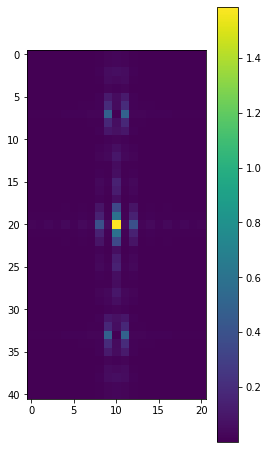

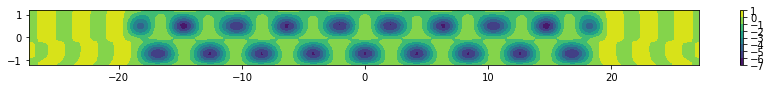

In [21]:
# Calculate plane-wave expansion coefficients of R 
N=10
M=5


def G(diff_coord):
    n,m = diff_coord
    return np.array([2*np.pi*n/Lx,2*np.pi*m/Ly])

def calc_fourier_coeffs(N,M, func):
    print("calculating R harmonics...",end="")
    dx = .05
    dy = .05
    fromx=-Lx/2
    tox=Lx/2
    fromy=-Ly/2
    toy=Ly/2
    nx = int((tox - fromx) / dx)
    ny = int((toy - fromy) / dy)
    x_, y_ = np.meshgrid(np.linspace(fromx, tox, nx, endpoint=False),
                         np.linspace(fromy, toy, ny, endpoint=False),
                         indexing='ij')
    R_ = func(x_,y_)
    
    # The harmonics are going to range from -2N:2N and -2M:2M
    coeffs = np.empty([4*N+1,4*M+1], dtype=complex)
    for i,row in enumerate(coeffs):
        for j,entry in enumerate(row):
            n = i-2*N
            m = j-2*M
            Gx,Gy=G((n,m))
            basis = np.exp(-1j * (Gx*x_ + Gy*y_))
            integrand_ = np.multiply (R_,basis )
            int_along_x = np.trapz(integrand_, axis=1, dx=dx)
            int_total = np.trapz(int_along_x, dx=dy)
            coeffs[i][j] = int_total
    print("done!")
    return coeffs/Lx/Ly


def fetch_coeff(n,m,coeffs):
    rows,cols = coeffs.shape
    N=int((rows-1)/4)
    M = int((cols-1)/4)
    return coeffs[n+2*N][m+2*M]

RG = calc_fourier_coeffs(N,M,R)

def test_coefficients():
    #have a sample function, and test whether calculate_R_harmonics function is behaving properly
    print("testing coefficients")
    x_ = np.arange(-15, 15, 0.2)
    y_ = np.arange(0, cell_height, 0.2)
    x_, y_ = np.meshgrid(x_, y_)
    r_ = R(x_,y_)
    
    plt.figure(figsize=(4,8))
    h = plt.imshow(np.abs(RG))
    plt.colorbar()
#     plt.clim(-10,10)
    
    x_ = np.arange(-Lx/2, Lx/2, 0.2)
    y_ = np.arange(-Ly/2, Ly/2, 0.2)
    x_, y_ = np.meshgrid(x_, y_)
        
    def rebuild_func(x,y):
        n_ = np.arange(-2*N,2*N+1)
        m_ = np.arange(-2*M,2*M+1)
        n_,m_ = np.meshgrid(n_,m_,indexing='ij')
        Gx_ = 2*np.pi*n_/Lx
        Gy_ = 2*np.pi*m_/Ly
        basis = np.exp(1j*(Gx_*x+Gy_*y))
        summand = np.multiply(RG,basis)
        return np.sum(summand)
    vrebuild_func = np.vectorize(rebuild_func)
    rr_ = vrebuild_func(x_,y_)
    plt.figure(figsize=(15,1))
    h = plt.contourf(x_, y_, np.real(rr_))

    plt.colorbar()
    plt.show()
    
    
test_coefficients()

In [25]:
# Code for above eigen value equation:
import numpy as np
from scipy import integrate
import numpy.linalg as la

def generate_basis(N:int, M:int):
    """
    Generates an ordered basis, that is, an np array of tuples containing Bragg harmonics indicies in a particular order to be used to generate matrices for secular eqations.
    
    Returns
    -------
    A np array of tuples of 2 ints. The first int is Bragg harmonic index in N direction. The second in M direction.
    """
    # Assume that their are N fourier harmonics in the x direction and M along y
    n_ = np.arange(-N,N+1)
    m_ = np.arange(-M,M+1)
    # Then we choose to order the harmonics of u_G as a sum over n of sum over m
    basis = np.empty(len(n_)*len(m_),dtype=tuple)
    for i,n in enumerate(n_):
        for j,m in enumerate(m_):
            basis[i*len(m_)+j]=(n,m)
    return basis
basis = generate_basis(N,M)

def build_matrix(basis, entry_formula:callable):
    size = len(basis)
    matrix = np.empty([size,size],dtype=complex)
    for i in np.arange(0,size):
        for j in np.arange(0,size):
            row = basis[i]
            col = basis[j]
            matrix[i][j] = entry_formula(row, col)
    return matrix

def hamiltonian_formula(row,col,k):
    diag_term = 0
    if row==col:
        Gx,Gy = G(row)
        diag_term = .5*(Gx**2+(k+Gy)**2)
    n,m = tuple(np.subtract(row,col))
    return diag_term + fetch_coeff(n,m,RG)

def calc_eig(k):
    hamiltonian = build_matrix(basis, entry_formula = lambda row,col: hamiltonian_formula(row,col,k))
    eigval,eigvec = la.eig(hamiltonian)
    return eigval

num_eig = (2*N+1)*(2*M+1)

K=2*np.pi/np.sqrt(3)/b

k_ = np.linspace(0,K,100)
eig__ = np.empty([len(k_),num_eig],dtype=complex)

# print(k_.shape, eig__.shape)

for i,k in enumerate(k_):
    # calc_eig(k)
    eig__[i,:] = calc_eig(k)

print(eig__.shape)
print(num_eig)

(100, 231)
231


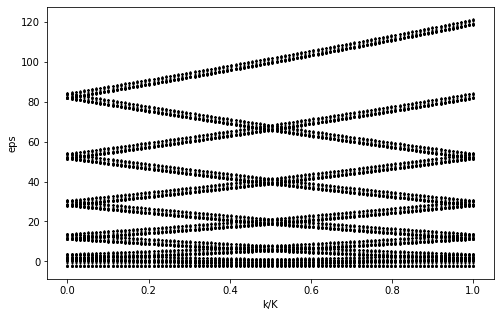

In [27]:
# plot eigenvalues
plt.figure(figsize=(8,5))
for i in np.arange(0,num_eig):
    plt.scatter(k_/K, np.real(eig__[:,i]),s=1,c='black')
plt.xlabel('k/K')
plt.ylabel('eps')
plt.show()